# California Housing Prices  

Using California census data to build a model of housing prices in the state.  
This data includes metrics such as the population, median income, and median housing price 
for each block group in California.  
Your model should learn from this data and be able to 
predict the median housing price in any district, given all the other metrics.


## Get the Data

In [108]:
# function to download dataset and store in the current directory

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [109]:
# load dataset in the data frame

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Analyze the data

In [110]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [111]:
# Shows info about data - col type and non null count

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [112]:
# Returns just the null count

housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [113]:
# Returns the categorical values and counts

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [114]:
# Describes the dataset

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


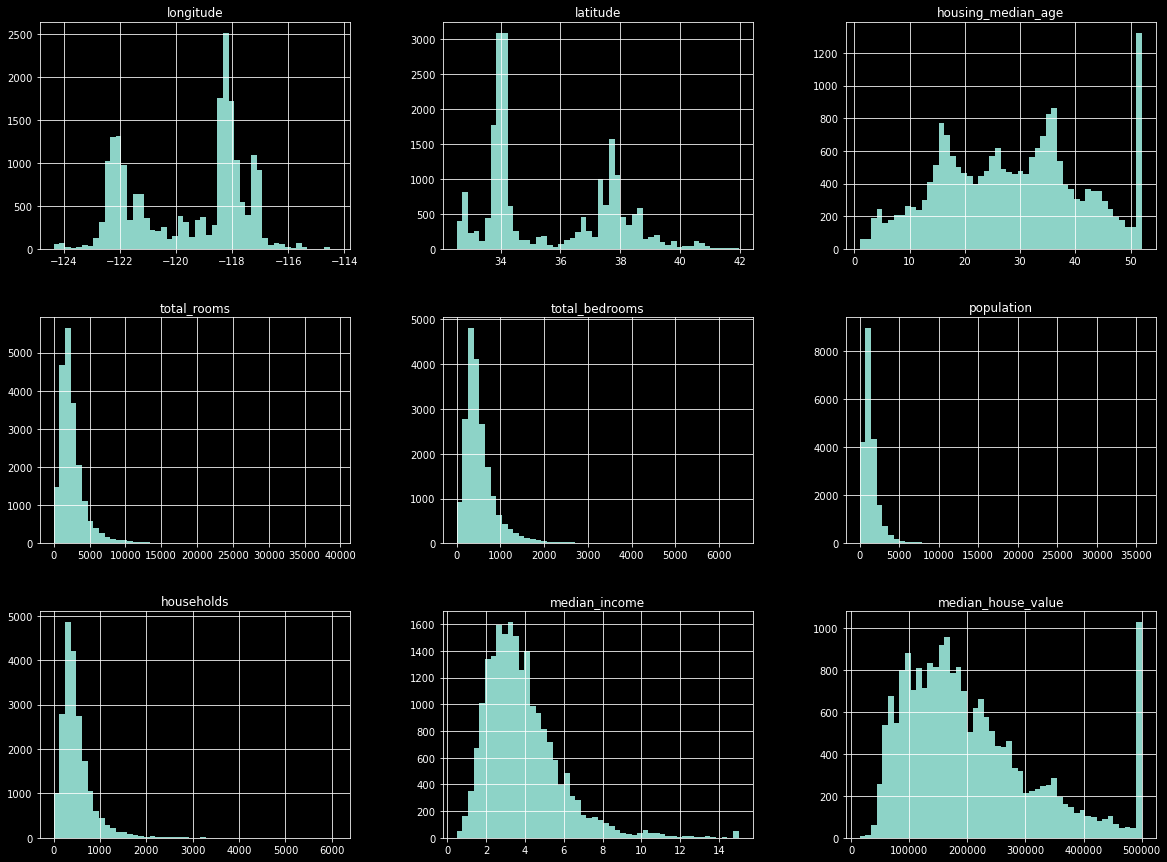

In [115]:
# Visual insights in the data to find anomilies / limits
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# X - value
# Y - counts
housing.hist(
    bins=50, # no of bars
    figsize = (20,15) # size of figure
)
plt.show()

### Observations 
* Curve is not bell shaped and tilted towards end, so some model may perform poorly. Hence need to give them bell shaped (e.g., by computing their logarithm)
* housing_median_age has a upper cap of 50+, so input values more than 50 also need to be capped as 50+
* median_income has upper cap of 15, so input values with more than 15 has to be capped to 15+
* median_house_value has lower cap of 15K and upper cap of 500k
    


In [116]:
# Optional
# Rearrange columns, move expected col to first
cols = ['median_house_value']  + [col for col in housing if col != 'median_house_value']
housing = housing[cols]
housing.head()

,median_house_value,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,452600.0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,358500.0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,352100.0,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,341300.0,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
4,342200.0,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY


The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to 0, then y generally goes up”)

## Correlations

In [117]:
# Find correlations - 
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

# Observations median_income is highly correlated (positively) to median_house_value

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<AxesSubplot:>

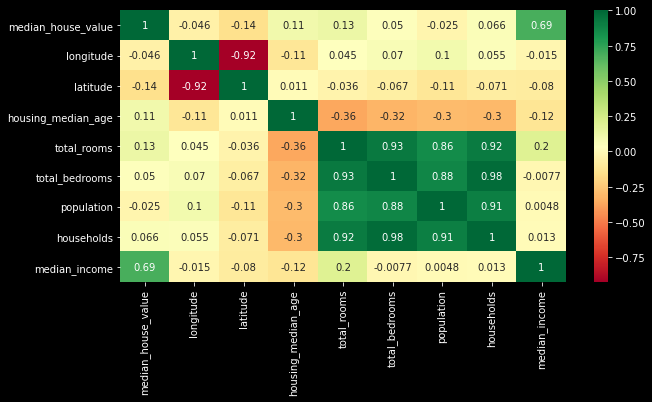

In [118]:
import seaborn as sns

# Visualize correlations
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")

### Observations
It is clear median income is highly correlated (linearly)

### Create Test Set

We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute


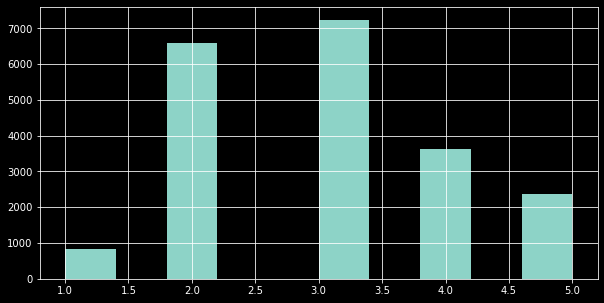

In [119]:
# panda cut bin values in descrete intervals
# median_income ranges from 0.5 - 15
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist(
    figsize=(10, 5), 
    bins=10
)
plt.show()

In [120]:
# Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

# n_splits : No of iterations (no of times it will do split by reshuffling)
stratifiedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, text_index in stratifiedSplit.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[text_index]

# Verify if test set has equal distribution of categories
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [121]:
# drop the income_cat attribute from train and test set 
for _set in (strat_test_set, strat_train_set):
    _set.drop("income_cat", axis=1, inplace=True)

/Users/goutasin/opt/anaconda3/envs/housing/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [122]:
# Verify if col is dropped
strat_train_set.head()

,median_house_value,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,286600.0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,340600.0,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,196900.0,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,46300.0,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,254500.0,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


## Visualize the data to gain insights

So far we have only taken a quick glance at the data to get a general understanding of the kind of data we are manipulating. Now the goal is to go into a little more depth.  
We need to make sure we have put the test set aside and you are only exploring the training set. 

#### Geographical Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

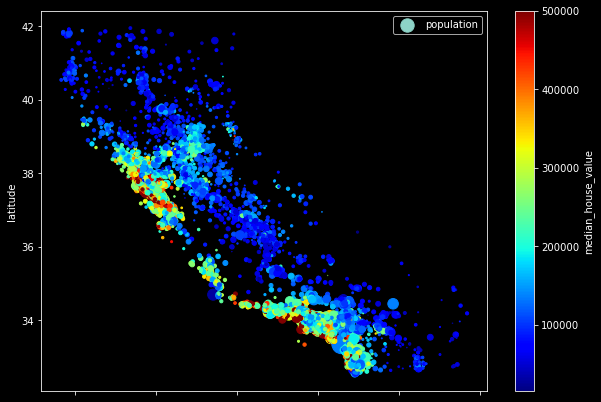

In [123]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", 
             s=housing["population"]/100, label="population", figsize = (10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
            )

### Observations

Median House Value is more near ocean

## Experimenting with attribute combinations
* The total number of rooms in a district is not very useful if you don’t know how many households there are. What we really want is the number of rooms per household
* Similarly, the total number of bedrooms by itself is not very useful: we probably want to compare it to the number of rooms.
* Population per household also seems like an interesting attribute combination to look at. 

In [126]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
housing.head()

,median_house_value,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,286600.0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,0.223852,2.094395
18632,340600.0,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.008850,0.159057,2.707965
14650,196900.0,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,0.241291,2.025974
3230,46300.0,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,0.200866,4.135977
3555,254500.0,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.505810,0.231341,3.047847


### Correlation with new attributes

In [127]:
corr_mat = housing.corr()
corr_mat["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Observations
* New attribute `bedrooms_per_room` is negavtively coorelated

## Prepare data for ML model

In [130]:
# Separate the features and labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

`total_bedrooms` attribute has some missing values. We have three options :
1. Get rid of corresponding districts.  
```
housing.dropna(subset=["total_bedrooms"])
```
2. Get rid of whole attribute.  
```
housing.drop("total_bedrooms", axis=1)
```
3. Set the values to some value (zero, mean, median etc).
```
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

#### Cleaning via SimpleImputer

Imputation transformer for completing missing values. Imputation strategy - `mean`, `median`, `most_frequent` and `constant`.

* Can create median of entire data set
* Cannot work with text values except `constant` strategy

In [135]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# median will work only with numerical data
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

# Imputer has not computer values 
print(imputer.statistics_)
print(housing_num.median())

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64


In [140]:
# Transform training set by replacing median value
X = imputer.transform(housing_num) # Returns transformed numpy array
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # Converts to data frame
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Categorical Value

* **Ordinal Encoder** : For related categories, assigning them weights like good -> better -> best.
* **One Hot Encoding** : For unrelated categories, assigning them 0 or 

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). 

In [142]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [143]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # returns sparse matrix saving memory by storing only useful attribute like non-zero 

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [145]:
housing_cat_1hot.toarray() # Converts to numpy array

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformers  


Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: `fit()` (returning self), `transform()`, and `fit_transform()`.
* Adding `TransformerMixin` as a base class will give us `fit_transform()`.
* Adding `BaseEstimator` as base class will give us `get_params()` and `set_params()` that will be useful for automatic hyperparameter tuning.

In [150]:
# Create custom transformer

from sklearn.base import TransformerMixin, BaseEstimator

rooms_index, bedrooms_index, population_index, household_index = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # Add custom attributes, returns numpy array

    def __init__(self, add_bedrooms_per_room=True):
        # We will verify if this attribute adds value to model precision
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        # In case we need to do only computation on X and not modify original matrix
        # here we calculate and store results in attributes 
        
        return self
    
    def transform(self, X):
        # Modifies original array
        
        rooms_per_household = X[:, rooms_index] / X[:, household_index]
        population_per_household = X[:, population_index] / X[:, household_index]
        if (self.add_bedrooms_per_room):
            bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
            
            # numpy c_ concatenates array col wise
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [152]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = attr_adder.fit_transform(housing.values)
housing_extra_attributes

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Feature Scaling

With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

* **Min Max Scaling (normalization):** Values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1. 

* **Standardization**: First it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called `StandardScaler` for standardization.


### Transformation Pipeline

In [154]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(steps=[
    # fill missing value with median
    ('imputer', SimpleImputer(strategy="median")),
    
    # our custom transformer - attributes adder
    ('attributes_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)),
    
    # Scale the set with help of StandardScaler
    ('standardScaler', StandardScaler())
], verbose=True)

In [155]:
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] .. (step 2 of 3) Processing attributes_adder, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing standardScaler, total=   0.0s


array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

#### Column Transformer for Combining categorical

In [159]:
from sklearn.compose import ColumnTransformer

num_attr = list(housing_num)
col_attr = ['ocean_proximity']


full_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_attr),
    ("cat", OneHotEncoder(), col_attr)
])

In [160]:
housing_prepared = full_pipeline.fit_transform(housing)

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] .. (step 2 of 3) Processing attributes_adder, total=   0.0s
[Pipeline] .... (step 3 of 3) Processing standardScaler, total=   0.0s


## Train the model

### Linear Regression

In [164]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(housing_prepared, housing_labels)

LinearRegression()

#### Measure the RMSE

In [166]:
from sklearn.metrics import mean_squared_error

housing_predictions = linear_reg.predict(housing_prepared)
lin_mse = mean_squared_error(y_true=housing_labels, y_pred=housing_predictions)
np.sqrt(lin_mse)

68628.19819848923

#### Observations

* Underfitting 

### Decison Tree 

In [168]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X=housing_prepared, y=housing_labels)

DecisionTreeRegressor()

#### Measure the RMSE

In [169]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(y_true=housing_labels, y_pred=housing_predictions)
np.sqrt(tree_mse)

0.0

#### Observations

* Overfitting 

### K-fold cross-validation

In [175]:
# Displays Scores

def display_scores(scores):
    print("Scores :", scores)
    print("Mean :", scores.mean())
    print("Standard Deviation :", scores.std())

In [176]:
# Linear Reqressor

from sklearn.model_selection import cross_val_score

lin_cv_scores = cross_val_score(linear_reg, X=housing_prepared, y=housing_labels, scoring="neg_mean_squared_error", cv=10) # 10 fold cv
lin_rmse_scores = np.sqrt(-lin_cv_scores)
display_scores(lin_rmse_scores)

Scores : [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean : 69052.46136345083
Standard Deviation : 2731.674001798342


In [177]:
# Decision Tree Reqressor

tree_cv_scores = cross_val_score(tree_reg, X=housing_prepared, y=housing_labels, scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-tree_cv_scores)
display_scores(tree_rmse_scores)

Scores : [69380.42121243 67787.91341032 71172.27708425 68650.11238876
 70874.143742   74136.41399225 71804.83811628 69801.5693849
 76884.53578376 68770.09187637]
Mean : 70926.2316991315
Standard Deviation : 2645.277939215804


#### Observations
* Linear Regression is performing far better than Decision tree regressor

### Random Forest Regressor

In [182]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X=housing_prepared, y=housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(y_true=housing_labels, y_pred=housing_predictions)
np.sqrt(forest_mse)

18638.62352117716

In [183]:
## Cross validations
forest_cv_score = cross_val_score(forest_reg, y=housing_labels, X=housing_prepared, cv=10, n_jobs=-1, verbose=10, scoring="neg_mean_squared_error")
forest_rmse_score = np.sqrt(-forest_cv_score)
display_scores(forest_rmse_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   18.3s remaining:   42.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   18.3s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   18.4s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished


Scores : [49643.89367623 47750.49708237 49639.02746442 52264.22432176
 49530.03326816 53387.20337318 48841.77228982 47657.43094357
 53069.17359095 49947.8366442 ]
Mean : 50173.10926546601
Standard Deviation : 1951.6686205184903


### Hyperparameter Tuning

#### Grid Search
Use cross-validation to evaluate all the possible combinations of hyperparameter values.  

In [188]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search_cv = GridSearchCV(forest_reg, param_grid, cv=5, verbose=4, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_cv.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=4)

In [ ]:
#### Observations

* To find total estimators:
    [0] n_estimators: 3, max_features: 4, total : 3*4 = 12
    [1] bootstrap: 1, n_estimators: 2, max_features: 3, total : 1*2*3 = 6
    Total estimators = 12 + 6 = 18
    Cross fold: 5
    Total training = 18*5 = 90
    

